In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read the movies metadata csv file

In [2]:
df = pd.read_csv("../Data Exploration and Preparation/master_data_with_imputed_budget_and_revenue.csv")

C:\Users\samsu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Only keep the numeric columns for our analysis. However, we'll keep titles also to interpret the results at the end of clustering. Note that this title column will not be used in the analysis.

In [3]:
df_numeric = df[['budget','popularity','revenue','runtime','vote_average','vote_count','title']]

In [4]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title
0,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,Jumanji
2,20000000.0,11.712900,32051917.0,101.0,6.5,92.0,Grumpier Old Men
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,Waiting to Exhale
4,11000000.0,8.387519,2112951.0,106.0,5.7,173.0,Father of the Bride Part II


Check if rows contain any null values

In [5]:
df_numeric.isnull().sum()

budget          1534
popularity         3
revenue         1537
runtime          260
vote_average       3
vote_count         3
title              3
dtype: int64

Drop all the rows with null values

In [6]:
df_numeric.dropna(inplace=True)

C:\Users\samsu\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's see the statistics for the votes counts for the movies data

In [7]:
df_numeric['vote_count'].describe()

count    43744.000000
mean       110.948473
std        499.853244
min          0.000000
25%          3.000000
50%          9.000000
75%         32.000000
max      14075.000000
Name: vote_count, dtype: float64

We see that a half of movies have been rated less than 10 times. For easier interpretability, let's take only the movies that have more than 30 votes, i.e. top 26% of the movies.

In [8]:
df_numeric['vote_count'].quantile(np.arange(.74,1,0.01))

0.74      30.00
0.75      32.00
0.76      35.00
0.77      37.00
0.78      40.00
0.79      43.00
0.80      47.00
0.81      51.00
0.82      57.00
0.83      62.00
0.84      70.00
0.85      77.00
0.86      87.00
0.87      99.00
0.88     113.00
0.89     133.00
0.90     156.00
0.91     188.00
0.92     227.00
0.93     280.00
0.94     348.42
0.95     441.00
0.96     596.28
0.97     848.00
0.98    1280.56
0.99    2299.85
Name: vote_count, dtype: float64

In [9]:
df_numeric = df_numeric[df_numeric['vote_count']>30]

In [10]:
df_numeric.shape

(11346, 7)

## Normalize data
Normalize the data with MinMax scaling provided by sklearn

In [11]:
from sklearn import preprocessing

In [12]:
minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric.drop('title',axis=1))

In [13]:
df_numeric_scaled = pd.DataFrame(minmax_processed, index=df_numeric.index, columns=df_numeric.columns[:-1])

In [14]:
df_numeric_scaled.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,0.078947,0.040082,0.133988,0.092360,0.810526,0.383367
1,0.171053,0.031075,0.094261,0.118586,0.726316,0.169610
2,0.052632,0.021389,0.011497,0.115165,0.684211,0.004343
3,0.042105,0.007045,0.029216,0.144812,0.642105,0.000214
4,0.028947,0.015315,0.000758,0.120867,0.600000,0.010111


## Apply K-Means Clustering

### What k to choose?
Let's fit cluster size 1 to 20 on our data and take a look at the corresponding score value.

In [15]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

In [16]:
score = [kmeans[i].fit(df_numeric_scaled).score(df_numeric_scaled) for i in range(len(kmeans))]

These score values signify how far our observations are from the cluster center. We want to keep this score value around 0. A large positive or a large negative value would indicate that the cluster center is far from the observations.

Based on these scores value, we plot an Elbow curve to decide which cluster size is optimal. Note that we are dealing with tradeoff between cluster size(hence the computation required) and the relative accuracy.

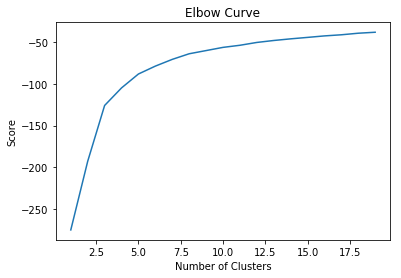

In [17]:
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Our Elbow point is around cluster size of 5. We will use k=5 to further interpret our clustering result.

### Fit K-Means clustering for k=5

In [18]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_numeric_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

As a result of clustering, we have the clustering label. Let's put these labels back into the original numeric data frame.

In [19]:
len(kmeans.labels_)

11346

In [20]:
df_numeric['cluster'] = kmeans.labels_

In [21]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
0,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story,1
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,Jumanji,2
2,20000000.0,11.712900,32051917.0,101.0,6.5,92.0,Grumpier Old Men,0
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,Waiting to Exhale,0
4,11000000.0,8.387519,2112951.0,106.0,5.7,173.0,Father of the Bride Part II,0


## Interpret clustering results

Let's see cluster sizes first.

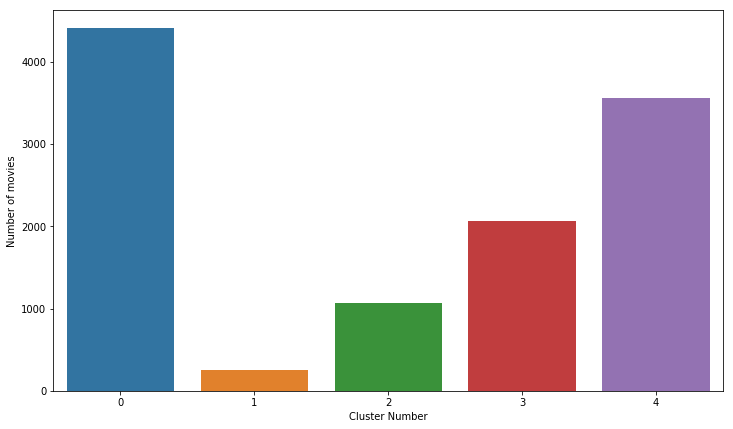

In [22]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,5,1),y=df_numeric.groupby(['cluster']).count()['budget'].values)
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of movies")

* We see that the cluster 1 is the largest and cluster 2 has the fewest number of movies.

Let's look at the cluster statistics.

In [23]:
df_numeric.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count
cluster,,,,,,
0,6.551984e+06,6.782005,1.580317e+07,100.300272,6.189877,174.661598
1,1.450915e+08,32.203355,6.358566e+08,126.371542,6.917787,4802.359684
2,7.017614e+07,12.301838,1.701177e+08,114.270775,6.238095,1180.261438
3,8.150244e+06,6.494351,1.117758e+07,93.613295,4.937312,123.855410
4,4.391993e+06,7.131047,1.724838e+07,109.724051,7.285541,307.125738


* We see that the cluster 1 (which is also the smallest), is the cluster of movies that received maximum number of votes(in terms of counts) and also have very high popularity and total runtime and net revenue. Let's see some of the movies that belong to this cluster.

In [25]:
df_numeric[df_numeric['cluster']==1].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
23686,210000000.0,18.495599,1.091405e+09,165.0,5.8,3136.0,Transformers: Age of Extinction,1
7320,175000000.0,15.387275,4.974099e+08,163.0,6.9,2841.0,Troy,1
13950,250000000.0,19.083723,9.339592e+08,153.0,7.4,5435.0,Harry Potter and the Half-Blood Prince,1
20048,250000000.0,23.253089,1.021104e+09,169.0,7.0,8427.0,The Hobbit: An Unexpected Journey,1
763,75000000.0,17.634197,8.169693e+08,145.0,6.7,3334.0,Independence Day,1


We see many big movie names in this cluster. So the results are intuitive.

* Cluster 2 represents the second smallest cluster in the results and has 2nd highest votes count and the most highly rated movies. The runtime for these movies is on the higher end and popularity score is also good. Let's see some of the movie names from this cluster.

In [26]:
df_numeric[df_numeric['cluster']==2].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
15644,44000000.0,6.273131,48190704.0,99.0,6.8,589.0,Charlie St. Cloud,2
1575,57000000.0,10.920124,152944660.0,144.0,7.2,1414.0,The Devil's Advocate,2
21046,100000000.0,11.913405,268426634.0,102.0,6.4,1143.0,Epic,2
1337,80000000.0,15.001681,280000000.0,126.0,6.6,1706.0,Batman Returns,2
21007,58000000.0,0.393865,44000000.0,119.0,6.1,1691.0,The Internship,2


* Lastly, let's take a look at the least successful movies. Cluster 3 represents the movies that recieved least number of votes and also has the smallest runtime, revenue and popularity score.

In [27]:
df_numeric[df_numeric['cluster']==3].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
12511,25000000.0,10.510245,6673422.0,104.0,5.2,128.0,What Just Happened,3
8147,0.0,4.299199,0.0,106.0,4.4,59.0,The Mangler,3
37656,2000000.0,2.281582,0.0,81.0,5.0,33.0,Rogue River,3
5191,0.0,4.176478,0.0,98.0,5.1,44.0,Return of the Killer Tomatoes!,3
9494,130000.0,10.652818,54667954.0,79.0,5.3,320.0,Open Water,3


As we can see this cluster also includes the movies for which our dataset has no information about the budget and revenue, hence there corresponding fields have 0 value in it. This pulls down the net revenue of the whole cluster. If we keep the cluster size slightly larger, we might get to see these movies clustered separately.

## Visualize clustering results using PCA

To apply PCA, let's first normalize the numerical values in the dataset

In [28]:
minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric.drop(['title','cluster'],axis=1))
df_numeric_scaled = pd.DataFrame(minmax_processed, index=df_numeric.index, columns=df_numeric.columns[:-2])
df_numeric_scaled.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,0.078947,0.040082,0.133988,0.092360,0.810526,0.383367
1,0.171053,0.031075,0.094261,0.118586,0.726316,0.169610
2,0.052632,0.021389,0.011497,0.115165,0.684211,0.004343
3,0.042105,0.007045,0.029216,0.144812,0.642105,0.000214
4,0.028947,0.015315,0.000758,0.120867,0.600000,0.010111


With PCA, let's first generate 2 principal components

In [29]:
from sklearn.decomposition import PCA

In [30]:
sklearn_PCA=PCA(n_components=2)

In [31]:
sk_PCA_out = sklearn_PCA.fit_transform(df_numeric_scaled)

We will insert the PC coordinates back into the original dataframe

In [32]:
df_numeric["2PCA_1"] = sk_PCA_out[:,0]

In [33]:
df_numeric["2PCA_2"] = sk_PCA_out[:,1]

In [34]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster,2PCA_1,2PCA_2
0,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story,1,0.310257,-0.062786
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,Jumanji,2,0.213872,0.020666
2,20000000.0,11.712900,32051917.0,101.0,6.5,92.0,Grumpier Old Men,0,0.002320,-0.014291
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,Waiting to Exhale,0,-0.015273,0.020022
4,11000000.0,8.387519,2112951.0,106.0,5.7,173.0,Father of the Bride Part II,0,-0.046533,0.051766


### Visualize K-Means clustering results on 2 principal component axes

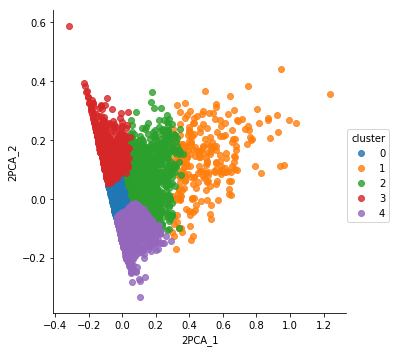

In [35]:
x=sns.lmplot(x='2PCA_1',y='2PCA_2',hue='cluster',data=df_numeric,fit_reg=False)

We can also use plot.ly to plot the same output

In [36]:
import plotly.plotly as py
import plotly.graph_objs as go

In [37]:
traces = []

for name in sorted(list(df_numeric['cluster'].unique())):

    trace = go.Scatter(
        x=df_numeric['2PCA_1'][df_numeric['cluster']==name],
        y=df_numeric['2PCA_2'][df_numeric['cluster']==name],
        mode='markers',
        name="Cluster "+str(name),
        marker=go.Marker(
            size=12,
            line=go.Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(showlegend=True,
                scene=go.Scene(xaxis=go.XAxis(title='PC1'),
                yaxis=go.YAxis(title='PC2'),))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Let's run PCA again, but for 3 Principal Components

In [38]:
sklearn_PCA=PCA(n_components=3)
sk_PCA_out = sklearn_PCA.fit_transform(df_numeric_scaled)
df_numeric["3PCA_1"] = sk_PCA_out[:,0]
df_numeric["3PCA_2"] = sk_PCA_out[:,1]
df_numeric["3PCA_3"] = sk_PCA_out[:,2]

In [39]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster,2PCA_1,2PCA_2,3PCA_1,3PCA_2,3PCA_3
0,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story,1,0.310257,-0.062786,0.310257,-0.062786,0.251216
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,Jumanji,2,0.213872,0.020666,0.213872,0.020666,0.036025
2,20000000.0,11.712900,32051917.0,101.0,6.5,92.0,Grumpier Old Men,0,0.002320,-0.014291,0.002320,-0.014291,-0.025705
3,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,Waiting to Exhale,0,-0.015273,0.020022,-0.015273,0.020022,-0.020967
4,11000000.0,8.387519,2112951.0,106.0,5.7,173.0,Father of the Bride Part II,0,-0.046533,0.051766,-0.046533,0.051766,0.000052


In [40]:
df_plot = df_numeric.drop(["3PCA_1","3PCA_2","3PCA_3","2PCA_1","2PCA_2","title"],axis=1)

### Visualize K-Means clustering results on 3 principal component axes

Prepapre data for plot.ly's 3d scatter plot

In [41]:
cluster0 = go.Scatter3d(
    x=df_numeric['3PCA_1'][df_numeric['cluster']==0],
    y=df_numeric['3PCA_2'][df_numeric['cluster']==0],
    z=df_numeric['3PCA_3'][df_numeric['cluster']==0],
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [42]:
cluster1 = go.Scatter3d(
    x=df_numeric['3PCA_1'][df_numeric['cluster']==1],
    y=df_numeric['3PCA_2'][df_numeric['cluster']==1],
    z=df_numeric['3PCA_3'][df_numeric['cluster']==1],
    mode='markers',
    marker=dict(
        color='rgb(144,190,43)',
        size=12,
        line=dict(
            color='rgba(195,157,108, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [43]:
cluster2 = go.Scatter3d(
    x=df_numeric['3PCA_1'][df_numeric['cluster']==2],
    y=df_numeric['3PCA_2'][df_numeric['cluster']==2],
    z=df_numeric['3PCA_3'][df_numeric['cluster']==2],
    mode='markers',
    marker=dict(
        color='rgb(195,193,47)',
        size=12,
        line=dict(
            color='rgba(63,108,242, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [44]:
cluster3 = go.Scatter3d(
    x=df_numeric['3PCA_1'][df_numeric['cluster']==3],
    y=df_numeric['3PCA_2'][df_numeric['cluster']==3],
    z=df_numeric['3PCA_3'][df_numeric['cluster']==3],
    mode='markers',
    marker=dict(
        color='rgb(147,225,106)',
        size=12,
        line=dict(
            color='rgba(196,107,151, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [45]:
cluster4 = go.Scatter3d(
    x=df_numeric['3PCA_1'][df_numeric['cluster']==4],
    y=df_numeric['3PCA_2'][df_numeric['cluster']==4],
    z=df_numeric['3PCA_3'][df_numeric['cluster']==4],
    mode='markers',
    marker=dict(
        color='rgb(141,167,145)',
        size=12,
        line=dict(
            color='rgba(129,120,31, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [46]:
data = [cluster0,cluster1,cluster2,cluster3,cluster4]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')